# Makine Öğrenmesi ile Afet Tweetlerinin Sınıflandırması

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from os import path
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
import xgboost
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as mt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [2]:
train_data = pd.read_csv("./datasets/train.csv")
test_data = pd.read_csv("./datasets/test.csv")
sample_submission = pd.read_csv("./datasets/sample_submission.csv")
df_train = train_data.copy()
df_test = test_data.copy()

In [3]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# Veri Setini Tanıma

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
df_train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [7]:
print(df_train.duplicated(['text', 'target']).sum())
print(df_train.duplicated(['text']).sum())

92
110


In [8]:
df_train = df_train.drop_duplicates(["text", "target"])
df_train = df_train.drop(index=df_train[df_train.duplicated('text', keep=False)].index)

In [9]:
len(df_train['keyword'].unique())

222

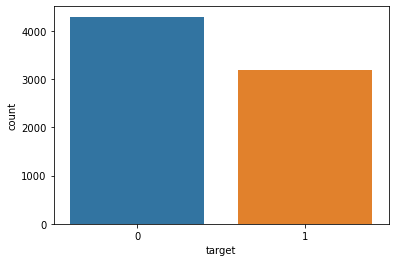

In [10]:
sns.countplot(x="target", data=df_train);

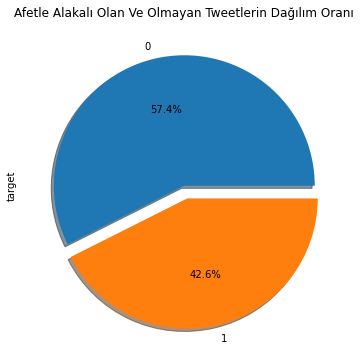

In [11]:
df_train["target"].value_counts().plot.pie(autopct='%1.1f%%', explode = [0, 0.1], figsize = (6, 6),shadow = True);
plt.title("Afetle Alakalı Olan Ve Olmayan Tweetlerin Dağılım Oranı");

## Keywordler

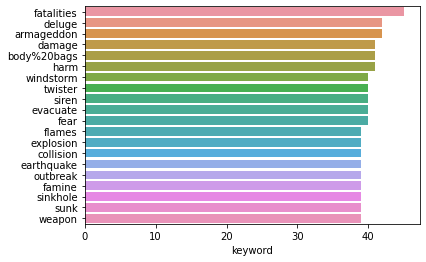

In [12]:
sns.barplot(y=df_train['keyword'].value_counts()[:20].index,x=df_train['keyword'].value_counts()[:20], orient='h');

In [13]:
df_train['keyword'].value_counts()[:20]

fatalities     45
deluge         42
armageddon     42
damage         41
body%20bags    41
harm           41
windstorm      40
twister        40
siren          40
evacuate       40
fear           40
flames         39
explosion      39
collision      39
earthquake     39
outbreak       39
famine         39
sinkhole       39
sunk           39
weapon         39
Name: keyword, dtype: int64

In [14]:
encoder = LabelEncoder()
df_train['keyword'] = encoder.fit_transform(df_train['keyword'])
df_test['keyword'] = encoder.transform(df_test['keyword'])

In [15]:
df_train.head()

,id,keyword,location,text,target
0,1,221,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,221,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,221,NaN,All residents asked to 'shelter in place' are ...,1
3,6,221,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,221,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Lokasyonlar

In [16]:
df_train['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"},inplace=True)

<AxesSubplot:xlabel='location'>

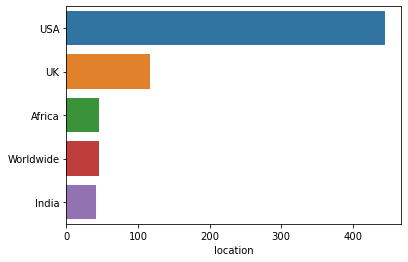

In [17]:
sns.barplot(y=df_train['location'].value_counts()[:5].index,x=df_train['location'].value_counts()[:5], orient='h')

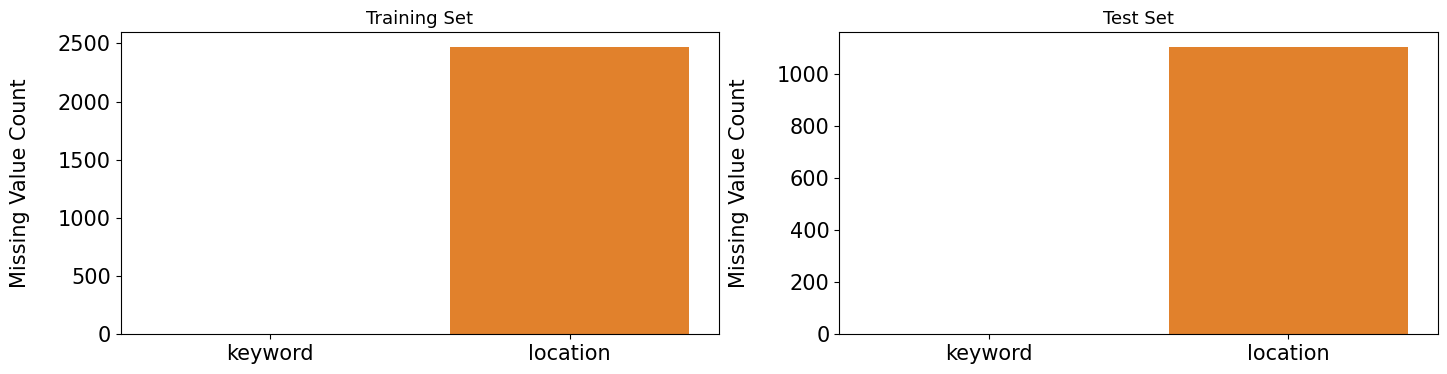

In [18]:
missing_cols = ['keyword', 'location']

# create bar plots for each set
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
for i, df in enumerate([df_train, df_test]):
    sns.barplot(x=missing_cols, y=df[missing_cols].isnull().sum().values, ax=axes[i])
    axes[i].set_ylabel('Missing Value Count', size=15, labelpad=20)
    axes[i].tick_params(axis='x', labelsize=15)
    axes[i].tick_params(axis='y', labelsize=15)
    axes[i].set_title(['Training Set', 'Test Set'][i], fontsize=13)

# impute missing values with "no_{col}"
for df in [df_train, df_test]:
    df[missing_cols] = df[missing_cols].fillna(f'no_{{col}}')

plt.show()

In [19]:
df_train["keyword"].fillna("None", inplace=True)
df_test["keyword"].fillna("None", inplace=True)

df_train["location"].fillna("None", inplace=True)
df_test["location"].fillna("None", inplace=True)

In [20]:
df = pd.concat([df_train, df_test], ignore_index=True)

In [21]:
df

,id,keyword,location,text,target
0,1,221,no_{col},Our Deeds are the Reason of this #earthquake M...,1.0
1,4,221,no_{col},Forest fire near La Ronge Sask. Canada,1.0
2,5,221,no_{col},All residents asked to 'shelter in place' are ...,1.0
3,6,221,no_{col},"13,000 people receive #wildfires evacuation or...",1.0
4,7,221,no_{col},Just got sent this photo from Ruby #Alaska as ...,1.0
...,...,...,...,...,...
10743,10861,221,no_{col},EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN
10744,10865,221,no_{col},Storm in RI worse than last hurricane. My city...,NaN
10745,10868,221,no_{col},Green Line derailment in Chicago http://t.co/U...,NaN
10746,10874,221,no_{col},MEG issues Hazardous Weather Outlook (HWO) htt...,NaN


In [22]:
df = df.drop(['id'], axis=1)
#df_test = df_test.drop(['id', 'location'], axis=1)

# Matematiksel İşlemler ve Basit Özellik Çıkarımı

## a. Harf/Karakter Sayısı

In [23]:
x_df = df.copy()

In [24]:
x_df["text"].str.len()

0         69
1         38
2        133
3         65
4         88
        ... 
10743     55
10744    139
10745     55
10746     65
10747     68
Name: text, Length: 10748, dtype: int64

In [25]:
x_df["harf_sayisi"] = x_df["text"].str.len()
x_df.head()

,keyword,location,text,target,harf_sayisi
0,221,no_{col},Our Deeds are the Reason of this #earthquake M...,1.0,69
1,221,no_{col},Forest fire near La Ronge Sask. Canada,1.0,38
2,221,no_{col},All residents asked to 'shelter in place' are ...,1.0,133
3,221,no_{col},"13,000 people receive #wildfires evacuation or...",1.0,65
4,221,no_{col},Just got sent this photo from Ruby #Alaska as ...,1.0,88


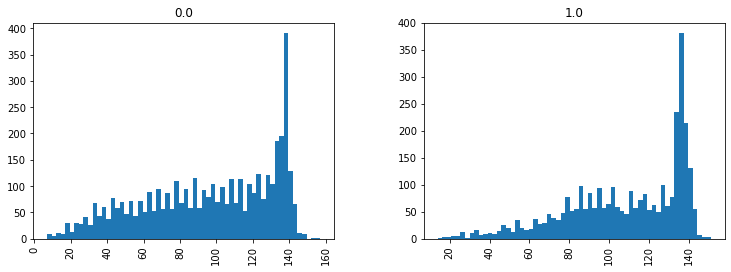

In [26]:
x_df.hist(column='harf_sayisi',by='target',bins=60,figsize=(12,4));

## b. Kelime Sayısı

In [27]:
x_df["kelime_sayisi"] = x_df["text"].apply(lambda x:len(str(x).split(" ")))
x_df.head()

,keyword,location,text,target,harf_sayisi,kelime_sayisi
0,221,no_{col},Our Deeds are the Reason of this #earthquake M...,1.0,69,13
1,221,no_{col},Forest fire near La Ronge Sask. Canada,1.0,38,7
2,221,no_{col},All residents asked to 'shelter in place' are ...,1.0,133,22
3,221,no_{col},"13,000 people receive #wildfires evacuation or...",1.0,65,9
4,221,no_{col},Just got sent this photo from Ruby #Alaska as ...,1.0,88,17


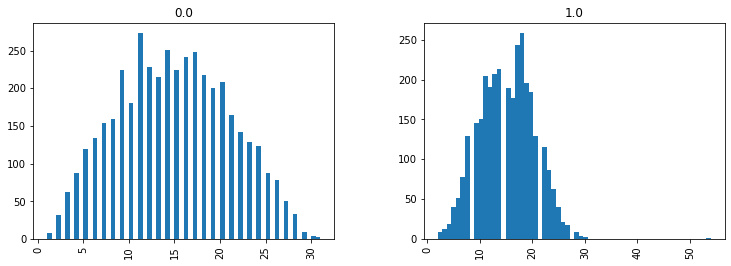

In [28]:
x_df.hist(column='kelime_sayisi',by='target',bins=60,figsize=(12,4));

## c. Sayilari Yakalamak & Saydirmak

In [29]:
x_df["sayi_sayisi"] = train_data["text"].apply(lambda x: len([x for x in x.split()
                                      if x.isdigit()]))

In [30]:
x_df.head()

,keyword,location,text,target,harf_sayisi,kelime_sayisi,sayi_sayisi
0,221,no_{col},Our Deeds are the Reason of this #earthquake M...,1.0,69,13,0.0
1,221,no_{col},Forest fire near La Ronge Sask. Canada,1.0,38,7,0.0
2,221,no_{col},All residents asked to 'shelter in place' are ...,1.0,133,22,0.0
3,221,no_{col},"13,000 people receive #wildfires evacuation or...",1.0,65,9,0.0
4,221,no_{col},Just got sent this photo from Ruby #Alaska as ...,1.0,88,17,0.0


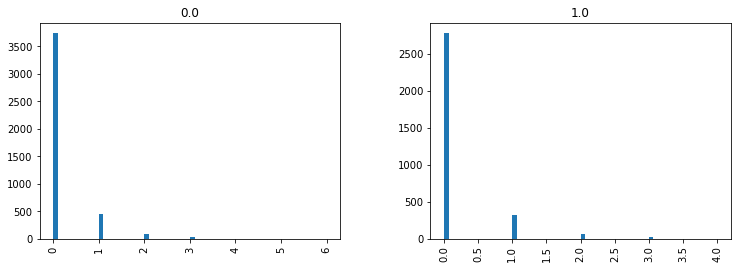

In [31]:
x_df.hist(column='sayi_sayisi',by='target',bins=60,figsize=(12,4));

In [32]:
x_df.describe().T

,count,mean,std,min,25%,50%,75%,max
keyword,10748.0,110.442966,64.495341,0.0,55.0,110.0,167.0,221.0
target,7485.0,0.425919,0.494515,0.0,0.0,0.0,1.0,1.0
harf_sayisi,10748.0,101.253163,33.874008,5.0,78.0,107.0,133.0,157.0
kelime_sayisi,10748.0,14.923148,5.793816,1.0,11.0,15.0,19.0,54.0
sayi_sayisi,7613.0,0.161960,0.468294,0.0,0.0,0.0,0.0,6.0


<Figure size 864x576 with 0 Axes>

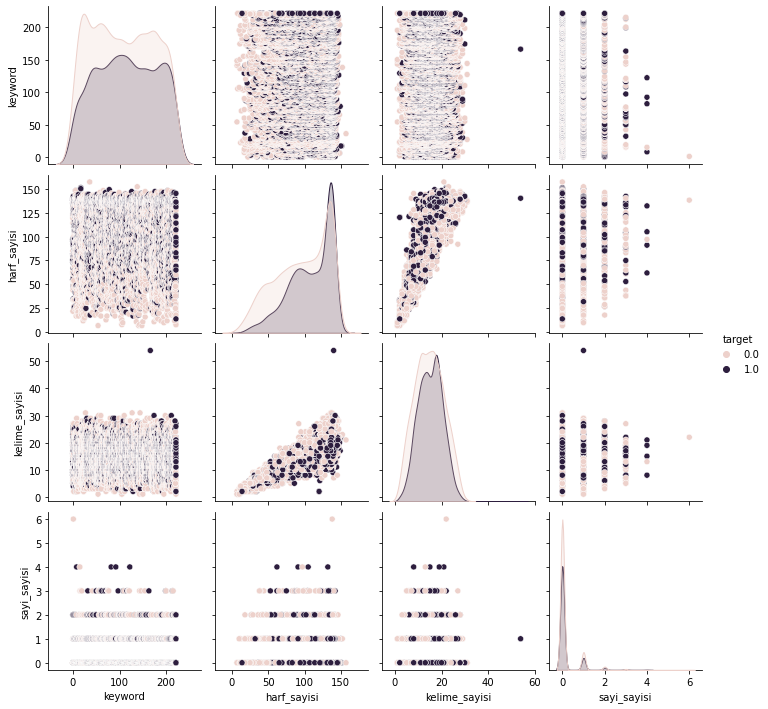

In [33]:
plt.figure(figsize=(12,8));
fg = sns.pairplot(data=x_df, hue="target")
plt.show(fg)

## Metin Ön İşleme

In [34]:
df = df.reset_index(drop=True)
df.head(50)

,keyword,location,text,target
0,221,no_{col},Our Deeds are the Reason of this #earthquake M...,1.0
1,221,no_{col},Forest fire near La Ronge Sask. Canada,1.0
2,221,no_{col},All residents asked to 'shelter in place' are ...,1.0
3,221,no_{col},"13,000 people receive #wildfires evacuation or...",1.0
4,221,no_{col},Just got sent this photo from Ruby #Alaska as ...,1.0
5,221,no_{col},#RockyFire Update => California Hwy. 20 closed...,1.0
6,221,no_{col},#flood #disaster Heavy rain causes flash flood...,1.0
7,221,no_{col},I'm on top of the hill and I can see a fire in...,1.0
8,221,no_{col},There's an emergency evacuation happening now ...,1.0
9,221,no_{col},I'm afraid that the tornado is coming to our a...,1.0


### URL Ayrımı

In [35]:
for i in range(len(df)):
    df["text"][i] = re.sub('(http|ftp|https)://([\w+?\.\w+])+([a-zA-Z0-9\~\!\@\#$\%\^\&\*_\-\=\+\\/\?\.\:\;\'\,]*)?', '', df["text"][i])
   
df.head()

,keyword,location,text,target
0,221,no_{col},Our Deeds are the Reason of this #earthquake M...,1.0
1,221,no_{col},Forest fire near La Ronge Sask. Canada,1.0
2,221,no_{col},All residents asked to 'shelter in place' are ...,1.0
3,221,no_{col},"13,000 people receive #wildfires evacuation or...",1.0
4,221,no_{col},Just got sent this photo from Ruby #Alaska as ...,1.0


### RT Ayrımı

In [36]:
for i in range(len(df)):
    df["text"][i] = re.sub('RT', '', df["text"][i])
    
df.head()

,keyword,location,text,target
0,221,no_{col},Our Deeds are the Reason of this #earthquake M...,1.0
1,221,no_{col},Forest fire near La Ronge Sask. Canada,1.0
2,221,no_{col},All residents asked to 'shelter in place' are ...,1.0
3,221,no_{col},"13,000 people receive #wildfires evacuation or...",1.0
4,221,no_{col},Just got sent this photo from Ruby #Alaska as ...,1.0


### Özel Karakterlerin Ayrımı

In [37]:
for i in range(len(df)):
    df["text"][i] = re.sub('[^a-zA-Z]', ' ', df["text"][i])
    
df.head(50)

,keyword,location,text,target
0,221,no_{col},Our Deeds are the Reason of this earthquake M...,1.0
1,221,no_{col},Forest fire near La Ronge Sask Canada,1.0
2,221,no_{col},All residents asked to shelter in place are ...,1.0
3,221,no_{col},people receive wildfires evacuation or...,1.0
4,221,no_{col},Just got sent this photo from Ruby Alaska as ...,1.0
5,221,no_{col},RockyFire Update California Hwy closed...,1.0
6,221,no_{col},flood disaster Heavy rain causes flash flood...,1.0
7,221,no_{col},I m on top of the hill and I can see a fire in...,1.0
8,221,no_{col},There s an emergency evacuation happening now ...,1.0
9,221,no_{col},I m afraid that the tornado is coming to our a...,1.0


### Büyük - Küçük Karakter Dönüşümü

In [38]:
df['text'] = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df.head()

,keyword,location,text,target
0,221,no_{col},our deeds are the reason of this earthquake ma...,1.0
1,221,no_{col},forest fire near la ronge sask canada,1.0
2,221,no_{col},all residents asked to shelter in place are be...,1.0
3,221,no_{col},people receive wildfires evacuation orders in ...,1.0
4,221,no_{col},just got sent this photo from ruby alaska as s...,1.0


### Stop Words 

In [39]:
import nltk
from nltk.corpus import stopwords
sw = stopwords.words('english')
sw

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [40]:
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

In [41]:
df.head(7000)

,keyword,location,text,target
0,221,no_{col},deeds reason earthquake may allah forgive us,1.0
1,221,no_{col},forest fire near la ronge sask canada,1.0
2,221,no_{col},residents asked shelter place notified officer...,1.0
3,221,no_{col},people receive wildfires evacuation orders cal...,1.0
4,221,no_{col},got sent photo ruby alaska smoke wildfires pou...,1.0
...,...,...,...,...
6995,207,UK,pov video captures violent landing amsterdam a...,1.0
6996,207,no_{col},storm blitzes traverse city disrupts managemen...,1.0
6997,207,Oshawa/Toronto,one violent belligerent storm enjoying watchin...,1.0
6998,207,"Very SW CA, USA....Draenor",iateyourfood yikes poor pup weird violent storm,1.0


### Seyrek Bulunan İfadelerin Silinmesi

In [42]:
least = pd.Series(" ".join(df["text"]).split()).value_counts().reset_index()
least.columns = ['words', 'tf']
least.head()

,words,tf
0,amp,508
1,like,488
2,fire,362
3,get,337
4,new,330


In [43]:
sil = least[least["tf"] < 50]
sil

,words,tf
369,thought,49
370,sunk,49
371,twister,49
372,group,49
373,casualties,49
...,...,...
20111,mcclain,1
20112,nyg,1
20113,follownflnews,1
20114,mcfadden,1


In [44]:
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in sil))

### Lemmitization

In [45]:
from textblob import Word
df['text'] = df['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) 

In [46]:
df[:20]

,keyword,location,text,target
0,221,no_{col},deed reason earthquake may allah forgive u,1.0
1,221,no_{col},forest fire near la ronge sask canada,1.0
2,221,no_{col},resident asked shelter place notified officer ...,1.0
3,221,no_{col},people receive wildfire evacuation order calif...,1.0
4,221,no_{col},got sent photo ruby alaska smoke wildfire pour...,1.0
5,221,no_{col},rockyfire update california hwy closed directi...,1.0
6,221,no_{col},flood disaster heavy rain cause flash flooding...,1.0
7,221,no_{col},top hill see fire wood,1.0
8,221,no_{col},emergency evacuation happening building across...,1.0
9,221,no_{col},afraid tornado coming area,1.0


## Terim Frekansı (Terimlerin Kullanım Sıklığı)

In [47]:
tf1 = pd.Series(' '.join(df['text']).lower().split()).value_counts().reset_index()
tf1.columns = ['words', 'tf']

In [48]:
tf1.head()

,words,tf
0,fire,517
1,amp,508
2,like,491
3,get,382
4,u,373


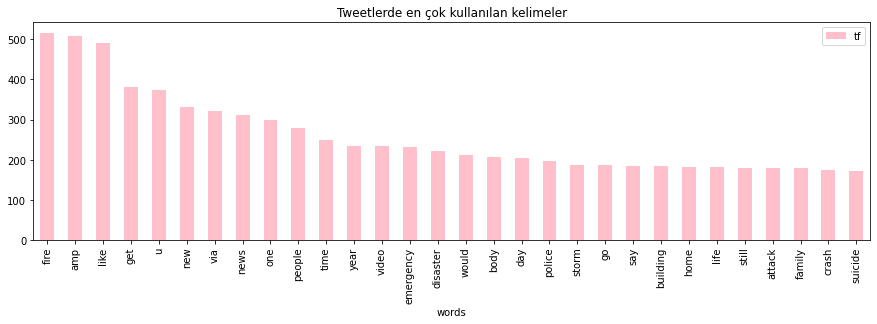

In [49]:
tf1[:30].plot.bar(x="words", y="tf", figsize=(15,4), color="pink");
plt.title('Tweetlerde en çok kullanılan kelimeler');

In [50]:
non_disaster_tweets_count = Counter(" ".join(df[df['target']==0]["text"]).split()).most_common(20)
non_disaster_tweets_count_df = pd.DataFrame(non_disaster_tweets_count, columns=["words", "freq"])
print("Afet içeriği olmayan tweetlerde en çok kullanılan 20 kelime:")
non_disaster_tweets_count_df

Afet içeriği olmayan tweetlerde en çok kullanılan 20 kelime:


,words,freq
0,like,254
1,amp,208
2,get,185
3,new,171
4,u,155
5,one,139
6,body,119
7,time,106
8,day,104
9,video,101


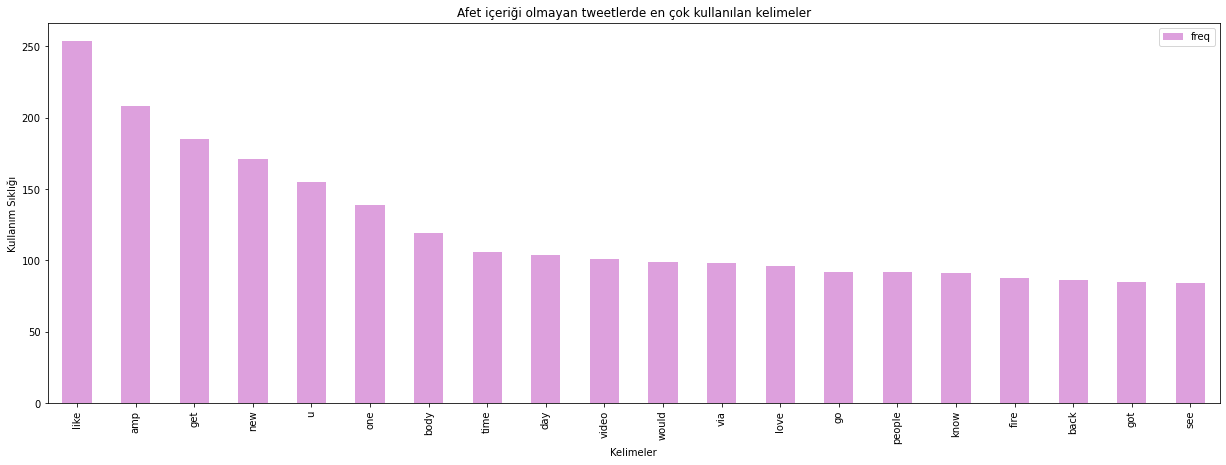

In [51]:
non_disaster_tweets_count_df.plot.bar(x="words", y="freq", figsize=(21,7), color="plum");
plt.title('Afet içeriği olmayan tweetlerde en çok kullanılan kelimeler');
plt.xlabel('Kelimeler')
plt.ylabel('Kullanım Sıklığı');

In [52]:
disaster_tweets_count = Counter(" ".join(df[df['target']==1]["text"]).split()).most_common(20)
disaster_tweets_count_df = pd.DataFrame(disaster_tweets_count, columns=["words", "freq"])
print("Afet içerikli tweetlerde en çok kullanılan 20 kelime:")
disaster_tweets_count_df

Afet içerikli tweetlerde en çok kullanılan 20 kelime:


,words,freq
0,fire,262
1,news,149
2,amp,134
3,via,119
4,disaster,117
5,california,114
6,u,110
7,police,107
8,suicide,106
9,people,102


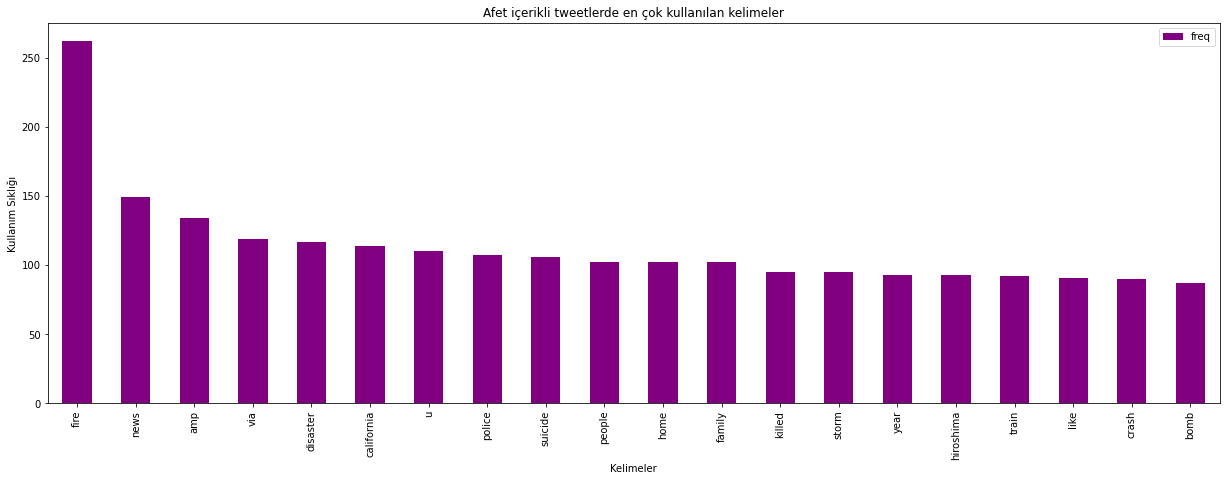

In [53]:
disaster_tweets_count_df.plot.bar(x="words", y="freq", figsize=(21,7), color="purple");
plt.title('Afet içerikli tweetlerde en çok kullanılan kelimeler');
plt.xlabel('Kelimeler')
plt.ylabel('Kullanım Sıklığı');

## Word Cloud

In [54]:
disaster_text = " ".join(i for i in (df[df['target']==1]['text']))

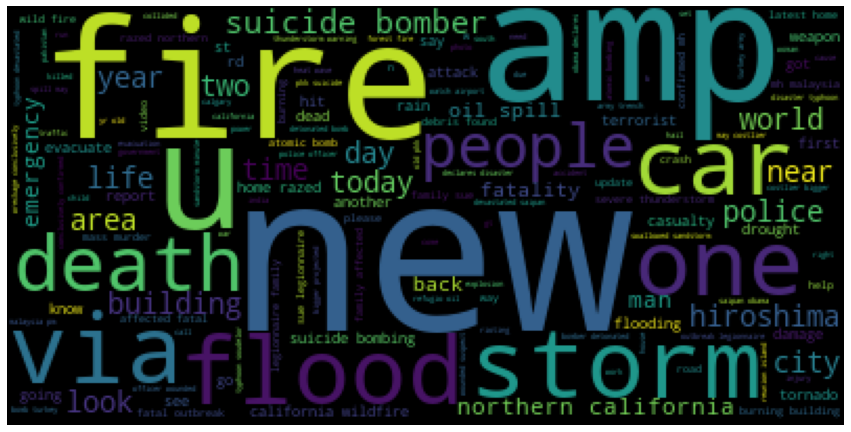

In [55]:
wordcloud = WordCloud(background_color= "black").generate(disaster_text)
plt.figure(figsize=[15,10])
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [56]:
non_disaster_text = " ".join(i for i in (df[df['target']==0]['text']))

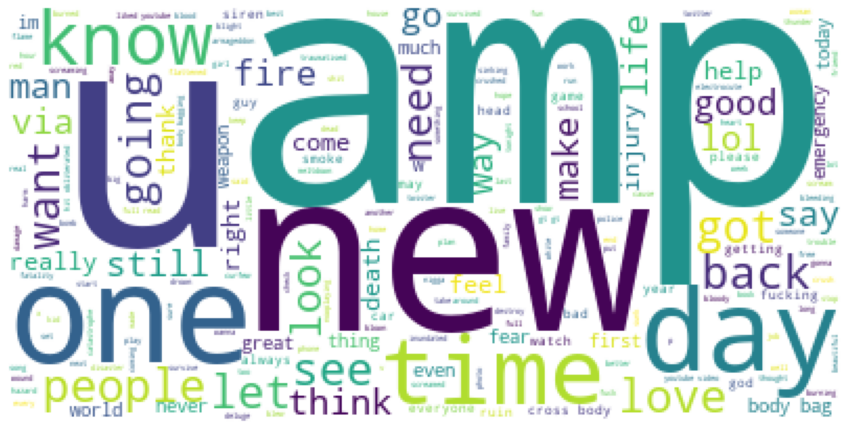

In [57]:
wordcloud = WordCloud(background_color= "white").generate(non_disaster_text)
plt.figure(figsize=[15,10])
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Degisken Muhendisligi

* Count Vectors
* TF-IDF Vectors (words, characters, n-grams)
* Word Embeddings

TF(t) = (Bir t teriminin bir dökümanda gözlenme frekansı) / (dökümandaki toplam terim sayısı) 

IDF(t) = log_e(Toplam döküman sayısı / içinde t terimi olan belge sayısı)

## Train - Test

In [58]:
y = df.target[:len(df_test)]
X = df.drop(["target","location"],axis=1)[:len(df_test)]

In [59]:
X, y

(      keyword                                               text
 0         221         deed reason earthquake may allah forgive u
 1         221              forest fire near la ronge sask canada
 2         221  resident asked shelter place notified officer ...
 3         221  people receive wildfire evacuation order calif...
 4         221  got sent photo ruby alaska smoke wildfire pour...
 ...       ...                                                ...
 3258       95  store fire alarm went today work evacuate like...
 3259       95  louis sad cancel show everyone leave evacuate ...
 3260       95              evacuate student throw dungeon stupid
 3261       95  u also flew bomb site world war ii warning let...
 3262       95  mygc broken powerlines evacuate gold coast tra...
 
 [3263 rows x 2 columns],
 0       1.0
 1       1.0
 2       1.0
 3       1.0
 4       1.0
        ... 
 3258    1.0
 3259    0.0
 3260    0.0
 3261    1.0
 3262    1.0
 Name: target, Length: 3263, dtype: f

In [60]:
X_train, X_test , y_train, y_test = model_selection.train_test_split(X, y, random_state=42, test_size=0.30)
X_train.head()

,keyword,text
1556,45,deep sleep dream bout fall cliff wake struggli...
435,11,casper rmg bestcomedyvine whats cracking cuz
1829,53,ina buted girl crush
237,5,fun filled happy hour simmons bar camden hands...
2820,82,heat wave relentless f feel like humidity rele...


## Count Vectors

In [61]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['text'])

CountVectorizer()

In [62]:
x_train_count = vectorizer.fit_transform(X_train['text'])
x_test_count = vectorizer.transform(X_test['text'])

In [63]:
vectorizer.get_feature_names()[:5]

['aa', 'aaaaaaallll', 'aace', 'aan', 'aaronthefm']

In [64]:
x_train_count.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

## TF- IDF

### Word Level TF-IDF

In [65]:
tf_idf_word_vectorizer = TfidfVectorizer()
tf_idf_word_vectorizer.fit(X_train['text'])
x_train_tf_idf_word = tf_idf_word_vectorizer.fit_transform(X_train['text'])
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(X_test['text'])

In [66]:
tf_idf_word_vectorizer.get_feature_names()[:5]

['aa', 'aaaaaaallll', 'aace', 'aan', 'aaronthefm']

### Ngram Level TF-IDF

In [67]:
tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range = (2,3))
tf_idf_ngram_vectorizer.fit(X_train['text'])
x_train_tf_idf_ngarm = tf_idf_ngram_vectorizer.fit_transform(X_train['text'])
x_test_tf_idf_ngram = tf_idf_ngram_vectorizer.transform(X_test['text'])

In [68]:
tf_idf_ngram_vectorizer.get_feature_names()[:5]

['aa battery',
 'aa battery swear',
 'aa mgm',
 'aa mgm grand',
 'aaaaaaallll even']

### Characters level TF-IDF

In [69]:
tf_idf_chars_vectorizer = TfidfVectorizer(analyzer = "char", ngram_range = (2,3))
tf_idf_chars_vectorizer.fit(X_train['text'])
x_train_tf_idf_chars = tf_idf_chars_vectorizer.fit_transform(X_train['text'])
x_test_tf_idf_chars = tf_idf_chars_vectorizer.transform(X_test['text'])

In [70]:
tf_idf_chars_vectorizer.get_feature_names()[:5]

[' a', ' aa', ' ab', ' ac', ' ad']

# Model Oluşturma 

In [71]:
all_performances = pd.DataFrame()
list_clf_name = []
list_x_test = []
list_pred = []
list_model = []

In [72]:
def fit_model(model, x_train_x, y_train):
    x_model = model.fit(x_train_x,y_train)
    return x_model

In [73]:
def model_name(model, vector_name):
    model_name= model.__class__.__name__
    if vector_name == "c":
        return model_name+"_count"
    elif vector_name == "n":
        return model_name+"_ngram"
    elif vector_name == "w":
        return model_name+"_word"
    elif vector_name == "ch":
        return model_name+"_chars"
    else:
        return

In [74]:
def add_list(name, model, x_test_x, y_pred):
    global list_clf_name, list_pred, list_model, list_x_test
    list_clf_name.append(name)
    list_model.append(model)
    list_x_test.append(x_test_x)
    list_pred.append(y_pred)

In [75]:
def add_all_performances(name, training_set_score, test_set_score, precision, recall, f1_score, AUC):
    global all_performances
    models = pd.DataFrame([[name, training_set_score, test_set_score, precision, recall, f1_score, AUC]],
                         columns=["model_name","training_set_score", "test_set_score",
                                  "precision", "recall", "f1_score", "AUC"])
    all_performances = all_performances.append(models, ignore_index=True)
    all_performances= all_performances.drop_duplicates()
    

In [76]:
def model_performance(x_train_x, x_test_x, model, vector_name):
    
    x_model = fit_model(model, x_train_x, y_train)
    
    name = model_name(model, vector_name)
    y_pred = x_model.predict(x_test_x)
    training_set_score= x_model.score(x_train_x, y_train)
    test_set_score = x_model.score(x_test_x, y_test)
    precision = mt.precision_score(y_test,y_pred)
    recall = mt.recall_score(y_test,y_pred)
    f1_score= mt.f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred) 
    
    add_list(name, model, x_test_x, y_pred)
    add_all_performances(name, training_set_score, test_set_score, precision, recall, f1_score, AUC)
    
    print(classification_report(y_test, y_pred, target_names=['non-disaster','disaster']))

## Logistic Regression

In [77]:
log_reg = linear_model.LogisticRegression()
model_performance(x_train_count, x_test_count, log_reg, "c")

              precision    recall  f1-score   support

non-disaster       0.82      0.89      0.85       609
    disaster       0.79      0.68      0.73       370

    accuracy                           0.81       979
   macro avg       0.80      0.78      0.79       979
weighted avg       0.81      0.81      0.80       979



In [78]:
log_reg = linear_model.LogisticRegression()
model_performance(x_train_tf_idf_word, x_test_tf_idf_word, log_reg, "w")

              precision    recall  f1-score   support

non-disaster       0.80      0.93      0.86       609
    disaster       0.85      0.63      0.72       370

    accuracy                           0.82       979
   macro avg       0.83      0.78      0.79       979
weighted avg       0.82      0.82      0.81       979



In [79]:
log_reg = linear_model.LogisticRegression()
model_performance(x_train_tf_idf_ngarm, x_test_tf_idf_ngram, log_reg, "n")

              precision    recall  f1-score   support

non-disaster       0.71      0.97      0.82       609
    disaster       0.88      0.34      0.49       370

    accuracy                           0.73       979
   macro avg       0.79      0.66      0.66       979
weighted avg       0.77      0.73      0.70       979



In [80]:
log_reg = linear_model.LogisticRegression()
model_performance(x_train_tf_idf_chars, x_test_tf_idf_chars, log_reg, "ch")

              precision    recall  f1-score   support

non-disaster       0.80      0.89      0.84       609
    disaster       0.77      0.63      0.70       370

    accuracy                           0.79       979
   macro avg       0.79      0.76      0.77       979
weighted avg       0.79      0.79      0.79       979



## Naive Bayes

In [81]:
nb = naive_bayes.MultinomialNB()
model_performance(x_train_count, x_test_count, nb, "c")

              precision    recall  f1-score   support

non-disaster       0.83      0.84      0.84       609
    disaster       0.74      0.72      0.73       370

    accuracy                           0.80       979
   macro avg       0.78      0.78      0.78       979
weighted avg       0.80      0.80      0.80       979



In [82]:
nb = naive_bayes.MultinomialNB()
model_performance(x_train_tf_idf_word, x_test_tf_idf_word, nb, "w")

              precision    recall  f1-score   support

non-disaster       0.81      0.93      0.87       609
    disaster       0.85      0.64      0.73       370

    accuracy                           0.82       979
   macro avg       0.83      0.79      0.80       979
weighted avg       0.82      0.82      0.82       979



In [83]:
nb = naive_bayes.MultinomialNB()
model_performance(x_train_tf_idf_ngarm, x_test_tf_idf_ngram, nb, "n")

              precision    recall  f1-score   support

non-disaster       0.73      0.96      0.83       609
    disaster       0.88      0.42      0.57       370

    accuracy                           0.76       979
   macro avg       0.81      0.69      0.70       979
weighted avg       0.79      0.76      0.73       979



In [84]:
nb = naive_bayes.MultinomialNB()
model_performance(x_train_tf_idf_chars, x_test_tf_idf_chars, nb, "ch")

              precision    recall  f1-score   support

non-disaster       0.76      0.95      0.84       609
    disaster       0.85      0.51      0.63       370

    accuracy                           0.78       979
   macro avg       0.81      0.73      0.74       979
weighted avg       0.79      0.78      0.76       979



## Random Forests

In [85]:
rf = ensemble.RandomForestClassifier()
model_performance(x_train_count, x_test_count, rf, "c")

              precision    recall  f1-score   support

non-disaster       0.79      0.89      0.84       609
    disaster       0.77      0.61      0.68       370

    accuracy                           0.79       979
   macro avg       0.78      0.75      0.76       979
weighted avg       0.78      0.79      0.78       979



In [86]:
rf = ensemble.RandomForestClassifier()
model_performance(x_train_tf_idf_word, x_test_tf_idf_word, rf, "w")

              precision    recall  f1-score   support

non-disaster       0.80      0.91      0.85       609
    disaster       0.81      0.64      0.71       370

    accuracy                           0.80       979
   macro avg       0.81      0.77      0.78       979
weighted avg       0.80      0.80      0.80       979



In [87]:
rf = ensemble.RandomForestClassifier()
model_performance(x_train_tf_idf_ngarm, x_test_tf_idf_ngram, rf, "n")

              precision    recall  f1-score   support

non-disaster       0.70      0.96      0.81       609
    disaster       0.85      0.33      0.47       370

    accuracy                           0.72       979
   macro avg       0.78      0.65      0.64       979
weighted avg       0.76      0.72      0.69       979



In [88]:
rf = ensemble.RandomForestClassifier()
model_performance(x_train_tf_idf_chars, x_test_tf_idf_chars, rf, "ch")

              precision    recall  f1-score   support

non-disaster       0.77      0.92      0.84       609
    disaster       0.80      0.55      0.65       370

    accuracy                           0.78       979
   macro avg       0.79      0.73      0.74       979
weighted avg       0.78      0.78      0.77       979



## XGBoost

In [89]:
xgb = xgboost.XGBClassifier()
model_performance(x_train_count, x_test_count, xgb, "c")

[00:57:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

non-disaster       0.81      0.90      0.85       609
    disaster       0.80      0.64      0.71       370

    accuracy                           0.80       979
   macro avg       0.80      0.77      0.78       979
weighted avg       0.80      0.80      0.80       979



In [90]:
xgb = xgboost.XGBClassifier()
model_performance(x_train_tf_idf_word, x_test_tf_idf_word, xgb, "w")

[00:57:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

non-disaster       0.79      0.91      0.84       609
    disaster       0.79      0.60      0.68       370

    accuracy                           0.79       979
   macro avg       0.79      0.75      0.76       979
weighted avg       0.79      0.79      0.78       979



In [91]:
xgb = xgboost.XGBClassifier()
model_performance(x_train_tf_idf_ngarm, x_test_tf_idf_ngram, xgb, "n")

[00:57:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

non-disaster       0.68      0.96      0.79       609
    disaster       0.80      0.24      0.37       370

    accuracy                           0.69       979
   macro avg       0.74      0.60      0.58       979
weighted avg       0.72      0.69      0.63       979



In [92]:
xgb = xgboost.XGBClassifier()
model_performance(x_train_tf_idf_chars, x_test_tf_idf_chars, xgb, "ch")

#print("Char Level TF-IDF Accuracy: ", accuracy)

[00:57:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

non-disaster       0.78      0.84      0.81       609
    disaster       0.70      0.60      0.64       370

    accuracy                           0.75       979
   macro avg       0.74      0.72      0.73       979
weighted avg       0.75      0.75      0.75       979



## SVC

In [93]:
svc = svm.SVC()
model_performance(x_train_count, x_test_count, svc, "c")

              precision    recall  f1-score   support

non-disaster       0.79      0.94      0.86       609
    disaster       0.86      0.59      0.70       370

    accuracy                           0.81       979
   macro avg       0.83      0.77      0.78       979
weighted avg       0.82      0.81      0.80       979



In [94]:
svc = svm.SVC()
model_performance(x_train_tf_idf_word, x_test_tf_idf_word, svc, "w")

              precision    recall  f1-score   support

non-disaster       0.80      0.94      0.86       609
    disaster       0.86      0.61      0.72       370

    accuracy                           0.82       979
   macro avg       0.83      0.78      0.79       979
weighted avg       0.82      0.82      0.81       979



In [95]:
svc = svm.SVC()
model_performance(x_train_tf_idf_ngarm, x_test_tf_idf_ngram, svc, "n")

              precision    recall  f1-score   support

non-disaster       0.70      0.97      0.82       609
    disaster       0.87      0.33      0.48       370

    accuracy                           0.73       979
   macro avg       0.79      0.65      0.65       979
weighted avg       0.77      0.73      0.69       979



In [96]:
svc = svm.SVC()
model_performance(x_train_tf_idf_chars, x_test_tf_idf_chars, svc, "ch")

              precision    recall  f1-score   support

non-disaster       0.79      0.90      0.84       609
    disaster       0.78      0.61      0.69       370

    accuracy                           0.79       979
   macro avg       0.79      0.75      0.76       979
weighted avg       0.79      0.79      0.78       979



## SGDClassifier

In [97]:
sgdc = linear_model.SGDClassifier()
model_performance(x_train_count, x_test_count, sgdc, "c")

              precision    recall  f1-score   support

non-disaster       0.81      0.84      0.83       609
    disaster       0.72      0.68      0.70       370

    accuracy                           0.78       979
   macro avg       0.77      0.76      0.76       979
weighted avg       0.78      0.78      0.78       979



In [98]:
sgdc = linear_model.SGDClassifier()
model_performance(x_train_tf_idf_word, x_test_tf_idf_word, sgdc, "w")

              precision    recall  f1-score   support

non-disaster       0.82      0.83      0.83       609
    disaster       0.71      0.71      0.71       370

    accuracy                           0.78       979
   macro avg       0.77      0.77      0.77       979
weighted avg       0.78      0.78      0.78       979



In [99]:
sgdc = linear_model.SGDClassifier()
model_performance(x_train_tf_idf_ngarm, x_test_tf_idf_ngram, sgdc, "n")

              precision    recall  f1-score   support

non-disaster       0.74      0.93      0.83       609
    disaster       0.81      0.47      0.59       370

    accuracy                           0.76       979
   macro avg       0.77      0.70      0.71       979
weighted avg       0.77      0.76      0.74       979



In [100]:
sgdc = linear_model.SGDClassifier()
model_performance(x_train_tf_idf_chars, x_test_tf_idf_chars, sgdc, "ch")

              precision    recall  f1-score   support

non-disaster       0.80      0.80      0.80       609
    disaster       0.67      0.68      0.68       370

    accuracy                           0.75       979
   macro avg       0.74      0.74      0.74       979
weighted avg       0.76      0.75      0.75       979



# Performans Değerlendirmesi

In [101]:
def display_all_confusion_matrix():
    f, ax = plt.subplots(6, 4, figsize=(20,40), sharey='row')
    ax = ax.flatten()

    for i in range(len(list_clf_name)):
        cf_matrix = confusion_matrix(y_test, list_pred[i])
        disp = ConfusionMatrixDisplay(cf_matrix)
        disp.plot(ax=ax[i], xticks_rotation=45)
        disp.ax_.set_title(list_clf_name[i]+"\nAccuracy:{accuracy:.4f}\nAUC:{auc:.4f}"
                           .format(accuracy= accuracy_score(y_test, list_pred[i]),auc= roc_auc_score(y_test, list_pred[i])),
                             fontsize=14)
        disp.im_.colorbar.remove()
        disp.ax_.set_xlabel('')
        if i!=0:
            disp.ax_.set_ylabel('')


    f.text(0.4, 0.1, 'Predicted label', ha='left')
    plt.subplots_adjust()


    f.colorbar(disp.im_)
    plt.show()

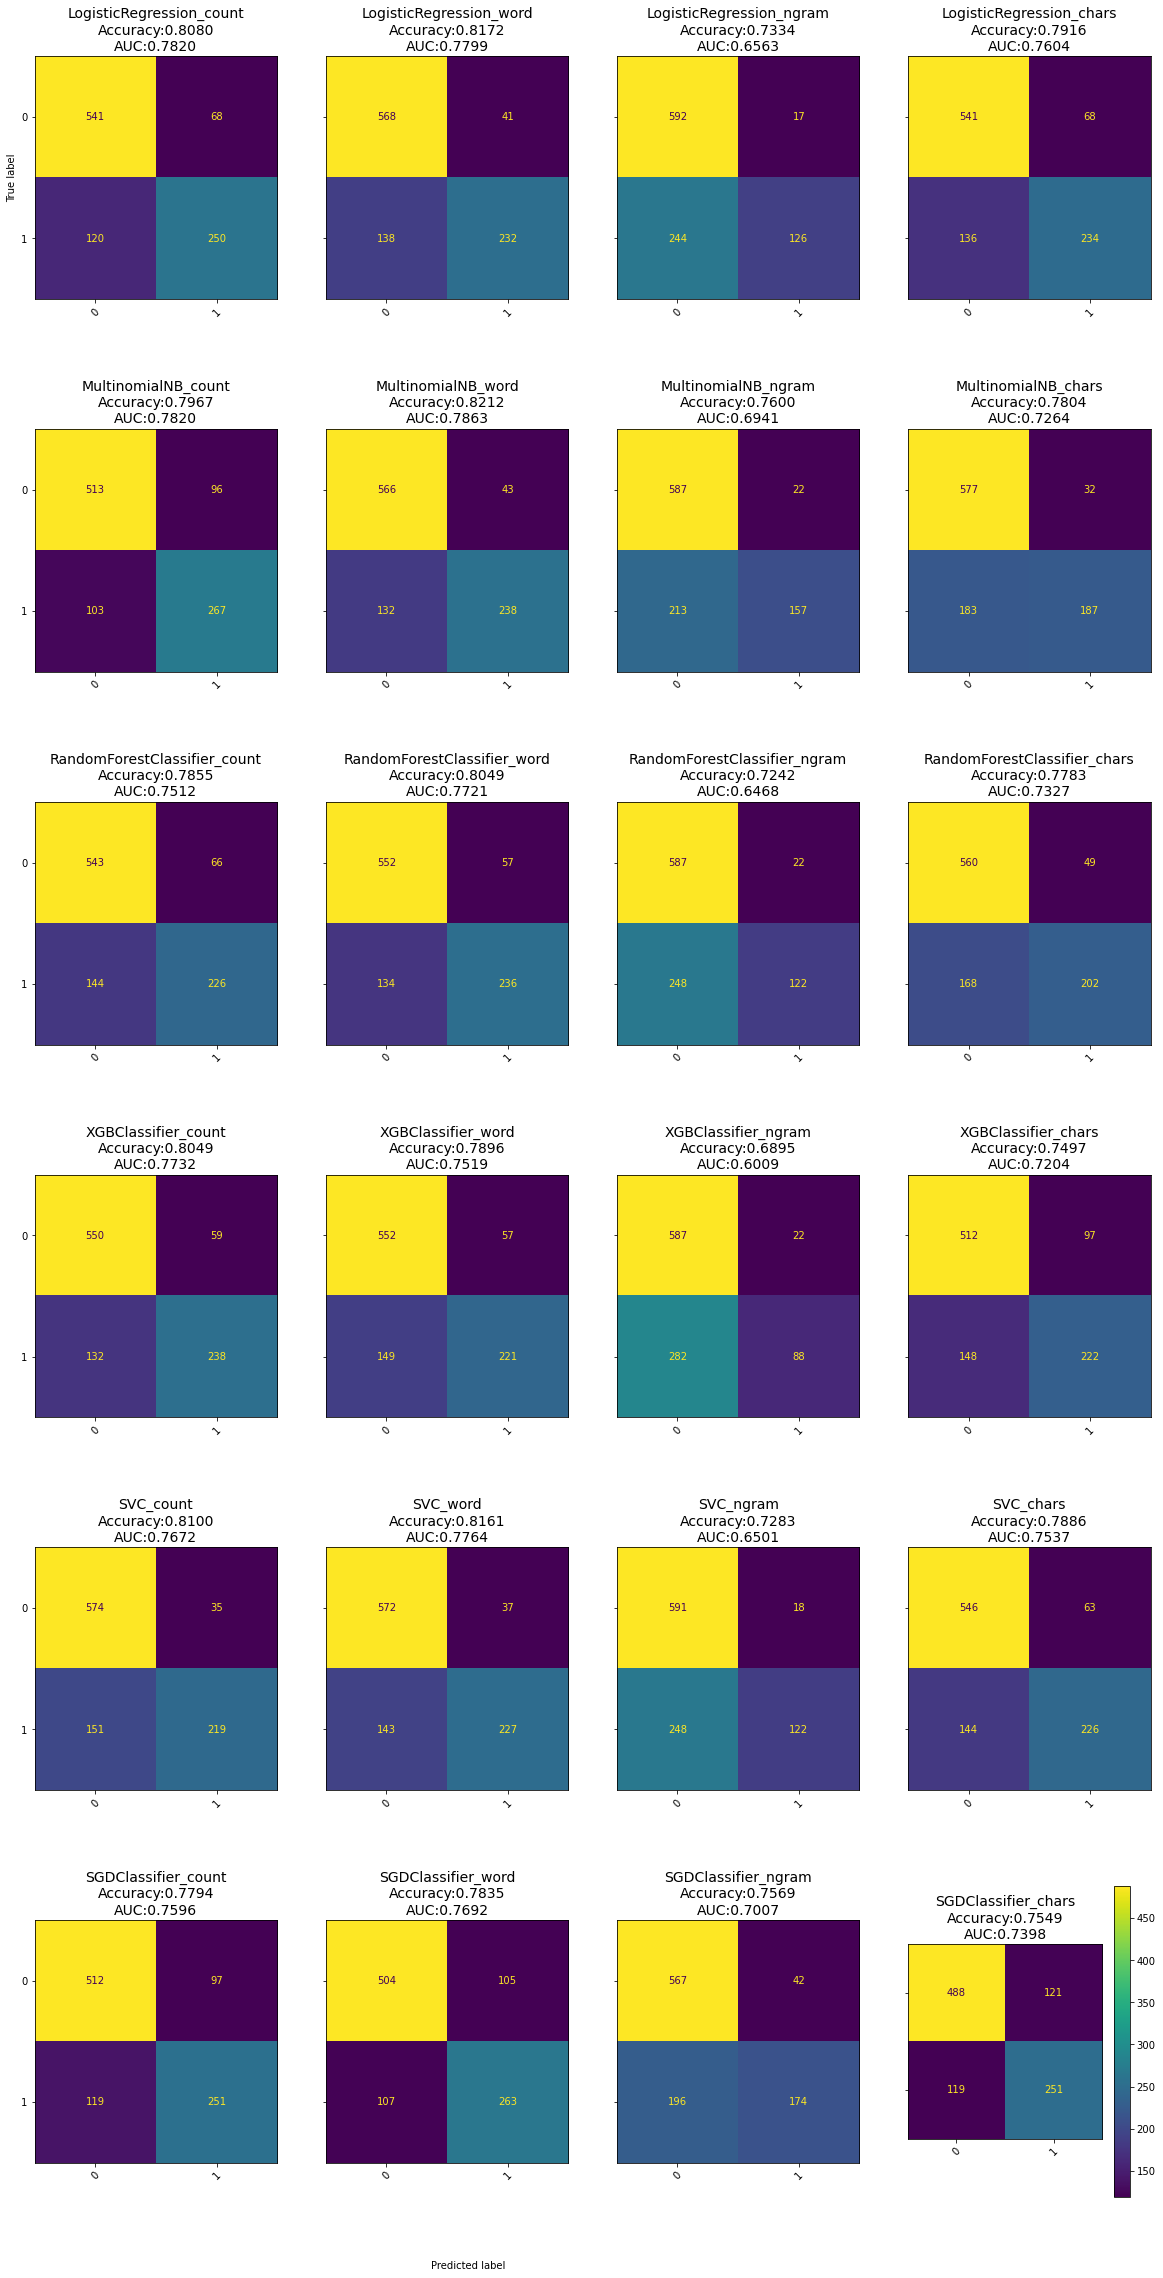

In [102]:
display_all_confusion_matrix()

In [103]:
all_performances.sort_values(by=['f1_score'], ascending=False)

,model_name,training_set_score,test_set_score,precision,recall,f1_score,AUC
5,MultinomialNB_word,0.920315,0.821246,0.846975,0.643243,0.731183,0.786318
4,MultinomialNB_count,0.941769,0.796731,0.735537,0.721622,0.728513,0.781993
0,LogisticRegression_count,0.975482,0.807967,0.786164,0.675676,0.726744,0.782009
1,LogisticRegression_word,0.893608,0.817160,0.849817,0.627027,0.721617,0.779852
17,SVC_word,0.979860,0.816139,0.859848,0.613514,0.716088,0.776379
12,XGBClassifier_count,0.860771,0.804903,0.801347,0.643243,0.713643,0.773182
21,SGDClassifier_word,0.988179,0.783453,0.714674,0.710811,0.712737,0.769199
9,RandomForestClassifier_word,0.991681,0.804903,0.805461,0.637838,0.711916,0.772121
16,SVC_count,0.956217,0.810010,0.862205,0.591892,0.701923,0.767210
20,SGDClassifier_count,0.990368,0.779367,0.721264,0.678378,0.699164,0.759550


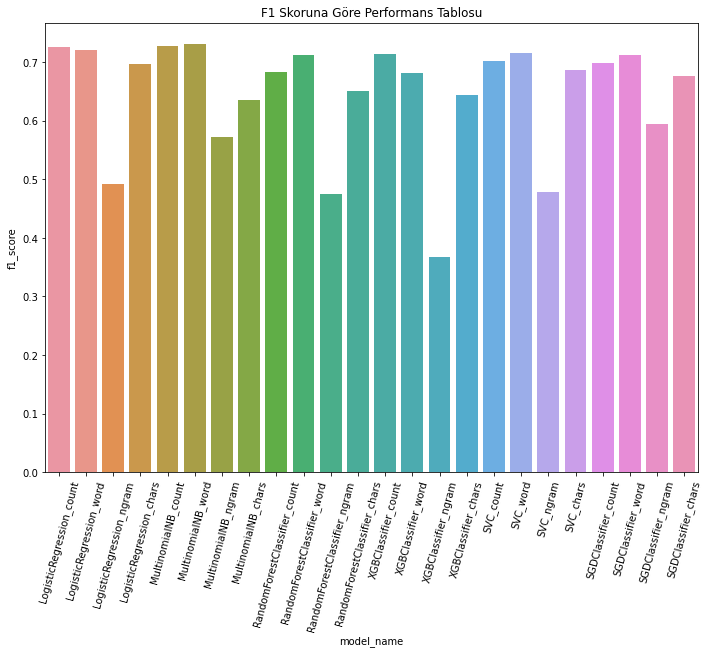

In [104]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
plt.xticks(rotation=75)
sns.barplot(x="model_name", y ="f1_score", data = all_performances, ax=ax);
title = plt.title('F1 Skoruna Göre Performans Tablosu')

## Hyperparameter Tuning

## Naive Bayes

In [105]:
# Define the hyperparameters to tune
param_grid = {
    'alpha': [11.25,11.5,11.75],  # smoothing parameter
    'fit_prior': [True, False],  # whether to learn class prior probabilities or use uniform priors
    'class_prior': [None, [0.3, 0.7], [0.5, 0.5]],  # prior probabilities of the classes
}

In [106]:
classifier = naive_bayes.MultinomialNB()

In [107]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='accuracy',
                           verbose=2)

### Count Vector

In [108]:
grid_search.fit(x_train_count, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ......alpha=11.25, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END ......alpha=11.25, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END ......alpha=11.25, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END ......alpha=11.25, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END ......alpha=11.25, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END .....alpha=11.25, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END .....alpha=11.25, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END .....alpha=11.25, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END .....alpha=11.25, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END .....alpha=11.25, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END alpha=11.25, class_prior=[0.3, 0.7], fit_prior=True; total time=   0.0s
[CV] END alpha=11.25, class_prior=[0.3, 0.7], fi

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [11.25, 11.5, 11.75],
                         'class_prior': [None, [0.3, 0.7], [0.5, 0.5]],
                         'fit_prior': [True, False]},
             scoring='accuracy', verbose=2)

In [109]:
# Print the best parameter combination and score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'alpha': 11.75, 'class_prior': None, 'fit_prior': True}
Best Score:  0.7859006103881148


In [110]:
best_classifier = grid_search.best_estimator_
accuracy = best_classifier.score(x_test_count, y_test)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.81511746680286


### Word Level TF-IDF

In [111]:
grid_search.fit(x_train_tf_idf_word, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ......alpha=11.25, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END ......alpha=11.25, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END ......alpha=11.25, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END ......alpha=11.25, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END ......alpha=11.25, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END .....alpha=11.25, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END .....alpha=11.25, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END .....alpha=11.25, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END .....alpha=11.25, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END .....alpha=11.25, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END alpha=11.25, class_prior=[0.3, 0.7], fit_prior=True; total time=   0.0s
[CV] END alpha=11.25, class_prior=[0.3, 0.7], fi

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [11.25, 11.5, 11.75],
                         'class_prior': [None, [0.3, 0.7], [0.5, 0.5]],
                         'fit_prior': [True, False]},
             scoring='accuracy', verbose=2)

In [112]:
# Print the best parameter combination and score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'alpha': 11.25, 'class_prior': None, 'fit_prior': False}
Best Score:  0.7666253982878422


## SVC (Word Level TF-IDF)

In [113]:
param_grid = {
    'C': [0.5, 1.0, 1.5],  # regularization parameter
    'kernel': ['linear', 'rbf'],  # kernel type
    'gamma': ['scale', 'auto']  # kernel coefficient for 'rbf'
}

In [114]:
classifier = SVC()

In [115]:
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='accuracy',
                           verbose=2)

In [116]:
grid_search.fit(x_train_tf_idf_word, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ..................C=0.5, gamma=scale, kernel=linear; total time=   0.2s
[CV] END ..................C=0.5, gamma=scale, kernel=linear; total time=   0.1s
[CV] END ..................C=0.5, gamma=scale, kernel=linear; total time=   0.1s
[CV] END ..................C=0.5, gamma=scale, kernel=linear; total time=   0.1s
[CV] END ..................C=0.5, gamma=scale, kernel=linear; total time=   0.1s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END ...................C=0.5, gamma=auto, kernel=linear; total time=   0.1s
[CV] END ...................C=0.5, gamma=auto, k

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.5, 1.0, 1.5], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy', verbose=2)

In [117]:
# Print the best parameter combination and score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'C': 1.0, 'gamma': 'scale', 'kernel': 'linear'}
Best Score:  0.7788936235556067


## Logistic Regression (Count Vector)

In [118]:
param_grid = {
    'C': [0.25,0.3,0.35],  # inverse regularization strength
    'penalty': ['l1', 'l2'],  # regularization type
    'solver': ['liblinear', 'saga']  # optimization algorithm
}

In [119]:
classifier = linear_model.LogisticRegression()

In [120]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='accuracy',
                           verbose=2)
grid_search.fit(x_train_count, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ...............C=0.25, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.25, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.25, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.25, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.25, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.25, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=0.25, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=0.25, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=0.25, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=0.25, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...............C=0.25, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.25, penalty=l2, solv

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.25, 0.3, 0.35], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy', verbose=2)

In [121]:
# Print the best parameter combination and score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'C': 0.25, 'penalty': 'l2', 'solver': 'saga'}
Best Score:  0.786342086068563


# En İyi Performans Gösteren Model

In [122]:
best_classifier = grid_search.best_estimator_

In [123]:
best_classifier

LogisticRegression(C=0.25, solver='saga')

In [124]:
model_performance(x_train_count, x_test_count, best_classifier, "c_tuned")

              precision    recall  f1-score   support

non-disaster       0.81      0.92      0.86       609
    disaster       0.83      0.66      0.73       370

    accuracy                           0.82       979
   macro avg       0.82      0.79      0.80       979
weighted avg       0.82      0.82      0.81       979



In [125]:
all_performances.sort_values(by=['f1_score'], ascending=False)

,model_name,training_set_score,test_set_score,precision,recall,f1_score,AUC
24,None,0.929510,0.819203,0.829352,0.656757,0.733032,0.787327
5,MultinomialNB_word,0.920315,0.821246,0.846975,0.643243,0.731183,0.786318
4,MultinomialNB_count,0.941769,0.796731,0.735537,0.721622,0.728513,0.781993
0,LogisticRegression_count,0.975482,0.807967,0.786164,0.675676,0.726744,0.782009
1,LogisticRegression_word,0.893608,0.817160,0.849817,0.627027,0.721617,0.779852
17,SVC_word,0.979860,0.816139,0.859848,0.613514,0.716088,0.776379
12,XGBClassifier_count,0.860771,0.804903,0.801347,0.643243,0.713643,0.773182
21,SGDClassifier_word,0.988179,0.783453,0.714674,0.710811,0.712737,0.769199
9,RandomForestClassifier_word,0.991681,0.804903,0.805461,0.637838,0.711916,0.772121
16,SVC_count,0.956217,0.810010,0.862205,0.591892,0.701923,0.767210


In [126]:
df

,keyword,location,text,target
0,221,no_{col},deed reason earthquake may allah forgive u,1.0
1,221,no_{col},forest fire near la ronge sask canada,1.0
2,221,no_{col},resident asked shelter place notified officer ...,1.0
3,221,no_{col},people receive wildfire evacuation order calif...,1.0
4,221,no_{col},got sent photo ruby alaska smoke wildfire pour...,1.0
...,...,...,...,...
10743,221,no_{col},eahquake safety los angeles safety fastener xrwn,NaN
10744,221,no_{col},storm ri worse last hurricane city amp others ...,NaN
10745,221,no_{col},green line derailment chicago,NaN
10746,221,no_{col},meg issue hazardous weather outlook hwo,NaN


In [127]:
X_pred = df[len(df_train):].drop("target",axis=1)
X_pred["text"]

7485                           happened terrible car crash
7486     heard earthquake different city stay safe ever...
7487     forest fire spot pond goose fleeing across str...
7488                  apocalypse lighting spokane wildfire
7489                    typhoon soudelor kill china taiwan
                               ...                        
10743     eahquake safety los angeles safety fastener xrwn
10744    storm ri worse last hurricane city amp others ...
10745                        green line derailment chicago
10746              meg issue hazardous weather outlook hwo
10747    cityofcalgary activated municipal emergency pl...
Name: text, Length: 3263, dtype: object

In [128]:
X_train['text']

1556    deep sleep dream bout fall cliff wake struggli...
435          casper rmg bestcomedyvine whats cracking cuz
1829                                 ina buted girl crush
237     fun filled happy hour simmons bar camden hands...
2820    heat wave relentless f feel like humidity rele...
                              ...                        
1095    st august turkish jet bombed village zergele q...
1130    cryptic guided pilot hiroshima bombing mission...
1294                kanger coil burning fast via r vaping
860                                                 blood
3174    emergency service unsure cope loss paging network
Name: text, Length: 2284, dtype: object

In [129]:
vectorizer = CountVectorizer()
vectorizer.fit_transform(X_train['text'])

<2284x6945 sparse matrix of type '<class 'numpy.int64'>'
	with 20138 stored elements in Compressed Sparse Row format>

In [130]:
X_pred_count = vectorizer.transform(X_pred["text"])

In [131]:
vectorizer.get_feature_names()[:5]

['aa', 'aaaaaaallll', 'aace', 'aan', 'aaronthefm']

In [132]:
X_pred_count.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [133]:
X_pred_count.shape

(3263, 6945)

In [134]:
x_train_count.shape

(2284, 6945)

In [135]:
y_pred = best_classifier.predict(X_pred_count)

In [136]:
sample_submission["target"].shape

(3263,)

In [137]:
 X_pred["text"].shape

(3263,)

In [138]:
y_pred.shape

(3263,)

In [139]:
data = {'tweet': X_pred["text"], 'location': X_pred['location'] , 'predicted_label': y_pred}
predicted_data = pd.DataFrame(data).reset_index(drop=True)

In [140]:
predicted_data['actual_label'] = sample_submission["target"].reset_index(drop=True)

In [141]:
predicted_data

,tweet,location,predicted_label,actual_label
0,happened terrible car crash,no_{col},0.0,0
1,heard earthquake different city stay safe ever...,no_{col},1.0,0
2,forest fire spot pond goose fleeing across str...,no_{col},1.0,0
3,apocalypse lighting spokane wildfire,no_{col},1.0,0
4,typhoon soudelor kill china taiwan,no_{col},0.0,0
...,...,...,...,...
3258,eahquake safety los angeles safety fastener xrwn,no_{col},0.0,0
3259,storm ri worse last hurricane city amp others ...,no_{col},1.0,0
3260,green line derailment chicago,no_{col},1.0,0
3261,meg issue hazardous weather outlook hwo,no_{col},0.0,0


In [142]:
sample_submission["target"].unique()

array([0], dtype=int64)

In [143]:
right_predictions = predicted_data[(predicted_data["predicted_label"] == predicted_data["actual_label"])]
right_predictions = right_predictions.reset_index(drop=True)
right_predictions

,tweet,location,predicted_label,actual_label
0,happened terrible car crash,no_{col},0.0,0
1,typhoon soudelor kill china taiwan,no_{col},0.0,0
2,probably still show life arsenal yesterday eh eh,no_{col},0.0,0
3,hey,no_{col},0.0,0
4,nice hat,no_{col},0.0,0
...,...,...,...,...
2395,see yr old pkk suicide bomber detonated bomb t...,no_{col},0.0,0
2396,conference attendee blue line airport derailed...,no_{col},0.0,0
2397,eahquake safety los angeles safety fastener xrwn,no_{col},0.0,0
2398,meg issue hazardous weather outlook hwo,no_{col},0.0,0


In [144]:
accuracy = len(right_predictions)*100/len(predicted_data)
accuracy

73.55194606190622

# Veri Tabanı Bağlantısı

In [145]:
import sqlite3

In [146]:
conn = sqlite3.connect('results.db')

In [147]:
try:
    conn.execute('''CREATE TABLE IF NOT EXISTS predicted_tweets (
                        id INTEGER PRIMARY KEY AUTOINCREMENT,
                        tweet TEXT,
                        location TEXT
                    )''')

    for i in range(len(right_predictions)):
        conn.execute('INSERT INTO predicted_tweets (tweet, location) VALUES (?, ?)',
                     (right_predictions['tweet'][i], right_predictions['location'][i]))
        
    conn.commit()
    conn.close()
    
except sqlite3.Error as e:
    print("Bir hata meydana geldi:", e)

finally:
    conn.close()